# Network Analysis Using Reinforcement Learning
## Spring 2022: Shaoyu Pei, Avery Peiffer

## Advisor: Dr. Mai Abdelhakim

**Note:** If you get any errors due to packages not being installed, please add them to the snippet below. We might have not encountered these errors due to already having those packages installed on our computers for other courses/projects/etc.

In [1]:
!pip3 install gym

In [13]:
import gym
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from gym import spaces
from gym.utils import seeding

## Part I: Environment Setup
In this section, we walk through the logic used to create the network environment that will be used later for the reinforcement learning algorithms. We represent a network as a graph, made up of edges and nodes. The nodes represent devices and the edges represent connections between devices. We use a partial mesh topology to define the network, which means that not all pairs of nodes are directly connected to each other (which would be a full mesh topology). 

All of the hyperparameters we use for creating the network environment:
* `network_size` is the number of nodes in the graph (including the source and destination nodes)
* `edge_prob` is the probability of an edge occurring between nodes when generating the graph
* `percent_mal` is the percentage of malicious nodes
* `attack_probs` are the bounds for the uniform distribution from which we will draw the attack probability of each malicious node

In [3]:
network_size = 20      
edge_prob = 0.1 
percent_mal = 0.3
attack_probs = [0.2, 0.8] 

Some helper methods to use when creating the graph:
* `render` visualizes the graph
* `random_edge` is used to make sure the graph is connected, since the graph is generated randomly and sometimes will not be one single component 

In [4]:
def render(graph):
    nx.draw(graph, with_labels=True)
    plt.show()

In [5]:
def random_edge(graph):
    edges = list(graph.edges)
    nonedges = list(nx.non_edges(graph))

    chosen_edge = random.choice(edges)
    chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])
    
    graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
    
    return graph

Here we create a random graph and add random edges until it is fully connected (meaning there is a path that takes you from a node to every other node). Then, we visualize the graph. 

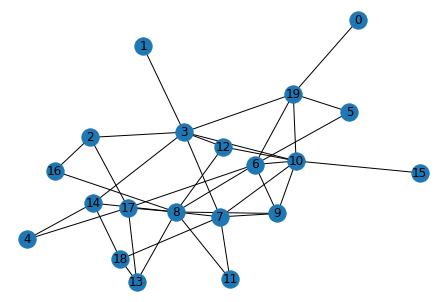

In [6]:
src = 0
dst = network_size - 1

G = nx.gnp_random_graph(network_size, edge_prob)

while not nx.is_connected(G):
    G = random_edge(G)

render(G)

We use the `agent` class to store information about each node. The `agent` class is created somewhat lazily, without any actual class definition. We will later define the attributes for each agent.

In [7]:
class agent:
    pass

We randomly assign some percentage (according to `percent_mal`) of the nodes to be malicious. We will assume that the source and destination nodes can't be malicious.

In [8]:
mal_nodes = []

num_mal = int(network_size * percent_mal)

while (num_mal > 0):
    rand = np.random.randint(0, network_size)
    
    if rand != 0 and rand != network_size-1 and rand not in mal_nodes:
        mal_nodes.append(rand)
        num_mal -= 1

For each node in the graph, we create an `agent` class for it. Each agent has the following attributes:
* `node`: The node in the graph that the agent corresponds to 
* `mal`: Whether or not the node is malicious
* `attack_prob`: Random number drawn from a uniform distribution with bounds highlighted in the hyperparameters section; this indicates how likely a malicious node is to "attack"

In [10]:
nodes = list(range(0, network_size))
agents = []

for node in nodes:
    a = agent()
    a.node = node
    
    if node in mal_nodes:
        a.mal = True
        a.attack_prob = np.random.uniform(attack_probs[0], attack_probs[1])
    else:
        a.mal = False
        a.attack_prob = 0
        
    agents.append(a)

This section provides an example of determining if a path from the source to the destination is corrupted. For each malicious node along the path, a random number is generated and compared to that node's attack probability to see if it will attack the path. The paths are generated using `nx.all_simple_paths()`. This function generates all paths from the source to the destination without doubling back on nodes.
* Note: `nx.all_simple_paths` might take some time to run if the number of nodes is high. 

In [11]:
def if_corrupted(path, verbose=False):
    for node in path: 
        attack_prob = agents[node].attack_prob
        attacked = random.uniform(0,1) < attack_prob
        
        if attacked:
            if verbose:
                print('Path = ', path)
                print('Node %d attacked this path' % node)
            return True
    return False

In [12]:
paths = list(nx.all_simple_paths(G, src, dst))
paths_corruption = []

for path in paths:
    paths_corruption.append(if_corrupted(path))

## Part 2: Reinforcement Learning (RL)

### RL Overview

In this section, we use everything from above to implement a class for our network environment. This allows us to actually train reinforcement learning algorithms. We modified [Laura D'Arcy's GraphRLnx repository](https://github.com/lauradarcy/graphRLnx) to create this class.

Please see the `tutorials/` folder for an overview of reinforcement learning. Essentially, we wish for our algorithm to learn the optimal path(s) from the source to the destination. We use the graph's `all_simple_paths` attribute as our action space - the possible paths our algorithm can choose. We assign a reward based on how many hops it takes to reach the destination from the source node. Additionally, our reward depends on whether or not the chosen path is corrupted. Over time, our algorithm will go from picking paths at random to picking the paths that are short and unlikely to be corrupted.

In [14]:
class graphRL(gym.Env):
    """
    will have fixed action space, but not all actions are valid within each state
    step function should have a function that tests if the chosen action is valid
    the observation returned will be the graph_tool graph, but the state will just be
    the adjacency matrix (? maybe, currently have obs space as the matrix)
    maybe step function just alters the given graph
    """
    
    def random_edge(self):
        edges = list(self.graph.edges)
        nonedges = list(nx.non_edges(self.graph))
        chosen_edge = random.choice(edges)
        chosen_nonedge = random.choice([x for x in nonedges if chosen_edge[0] == x[0] or chosen_edge[0] == x[1]])
        self.graph.add_edge(chosen_nonedge[0], chosen_nonedge[1])
        
    def is_corrupted(self, path, verbose=False):
        for node in path: 
            attack_prob = self.agents[node].attack_prob
            attacked = random.uniform(0,1) < attack_prob
            if attacked:
                if verbose:
                    print('Path = ', path)
                    print('Node %d attacked this path' % node)
                return True
        return False

    def __init__(self, network_size=10, edge_prob=1, percent_mal=0, attack_probs=[0, 0]):
        self.network_size = network_size
        self.src = 0
        self.dst = network_size - 1
        self.graph = nx.gnp_random_graph(network_size, edge_prob)
        
        while not nx.is_connected(self.graph):
            self.random_edge()
            
        self.mal_nodes = []
        num_mal = network_size * percent_mal
        
        while num_mal > 0:
            rand = np.random.randint(0, network_size)           
            if rand != src and rand != dst and rand not in self.mal_nodes:
                self.mal_nodes.append(rand)
                num_mal -= 1
            
        class agent:
            pass
        
        nodes = list(range(0, network_size))
        self.agents = []
        
        for node in nodes:
            a = agent()
            a.node = node
            
            if node in self.mal_nodes:
                a.mal = True
                a.attack_prob = np.random.uniform(attack_probs[0], attack_probs[1])
            else:
                a.mal = False
                a.attack_prob = 0
            
            self.agents.append(a)
            
        self.paths = list(nx.all_simple_paths(self.graph, self.src, self.dst))
               
        self.action_space = spaces.Discrete(len(self.paths))
        self.observation_space = spaces.MultiDiscrete(np.full((self.network_size, self.network_size), 2))
        self.time_step = 0
        self.observation = nx.to_numpy_matrix(self.graph).astype(int)
        self.seed_value = self.seed()
        
        # might need to throw in self.reset() here

    def render(self):
        nx.draw(self.graph, with_labels=True)
        plt.show()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        done = 0
        reward = 0
        assert self.action_space.contains(action)
        
        path = self.paths[action]
        num_hops = len(path)
        reward -= num_hops
        
        if self.is_corrupted(path):
            reward -= 10 # ARBITRARY
        
        self.time_step += 1
        return self.observation, reward, done, {"time_step": self.time_step}

    # Will have to change this if reset() is needed
    def reset(self):
        all_edges = list(self.graph.edges())
        self.graph.remove_edges_from(all_edges)
        self.time_step = 0
        self.observation = nx.to_numpy_matrix(self.graph).astype(int)
        return self.observation

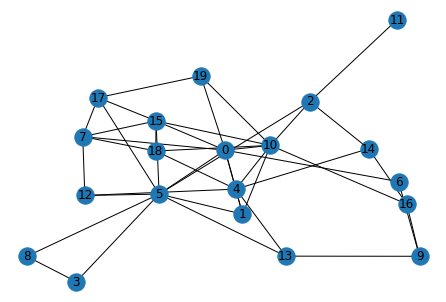

In [18]:
env = graphRL(network_size=20, edge_prob=0.1)
env.render()

for _ in range(1000):
    env.step(env.action_space.sample()) # take a random action
env.close()